# Task 1.1 - Dataset Exploration

### Load training data in a dataframe

In [147]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pywt

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

from collections import Counter
import struct
import gdown

In [118]:
# read data in binary format
def read_binary_from(ragged_array, bin_file):

    while True:

        chunk = bin_file.read(4)
        if not chunk:
            break

        sub_array_size = struct.unpack('i', chunk)[0]
        sub_array = np.array(struct.unpack(f'{sub_array_size}h', bin_file.read(sub_array_size * 2)))
        ragged_array.append(sub_array)

# read data
def load_data(filename: str, mode: str):

    ragged_array = []

    with open(filename, mode) as file:
        if mode == 'rb':
            read_binary_from(ragged_array, file)
        else:
            data = file.readlines()
            ragged_array = list(map(lambda p: int(p[0]), data))

    return ragged_array


In [153]:

data_url = "https://drive.google.com/drive/folders/1MyX__3hRiPkWHGFKqZXpOyq32KQpPDTR?usp=sharing"
gdown.download_folder(data_url, quiet=False)

ecg_data_path = 'data/X_train.bin'
labels_path = 'data/y_train.csv'

ecg_data = load_data(ecg_data_path, 'rb')
labels = load_data(labels_path, 'r')

Retrieving folder contents


Processing file 1k4zVB77UNftw5BgCX0kr2FlWC0TV9Gz1 X_test.bin
Processing file 1T_-zQOkEPpMpYTV1OeDepsKwr8TASS_v X_train.bin
Processing file 139Kj5xAmTuy2YBzygzNqIzBFScaWywEC y_train.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1k4zVB77UNftw5BgCX0kr2FlWC0TV9Gz1
To: /Users/mzm/Documents/Uni/SS25/AMLS/AMLS Project/data/X_test.bin
100%|██████████| 51.5M/51.5M [00:01<00:00, 27.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1T_-zQOkEPpMpYTV1OeDepsKwr8TASS_v
From (redirected): https://drive.google.com/uc?id=1T_-zQOkEPpMpYTV1OeDepsKwr8TASS_v&confirm=t&uuid=affd0694-c69c-4195-af30-ff14a85dbff7
To: /Users/mzm/Documents/Uni/SS25/AMLS/AMLS Project/data/X_train.bin
100%|██████████| 121M/121M [00:04<00:00, 24.7MB/s] 
Downloading...
From: https://drive.google.com/uc?id=139Kj5xAmTuy2YBzygzNqIzBFScaWywEC
To: /Users/mzm/Documents/Uni/SS25/AMLS/AMLS Project/data/y_train.csv
100%|██████████| 12.4k/12.4k [00:00<00:00, 10.4MB/s]
Download completed


In [120]:
df = pd.DataFrame({
    'Data': ecg_data, 
    'Class': labels
})
df['Lengths'] = df['Data'].apply(lambda ls: len(ls))
print(f'Number of all Data Points: {df["Data"].count()}')
df.head()

Number of all Data Points: 6179


,Data,Class,Lengths
0,"[-217, -246, -294, -344, -363, -371, -377, -37...",2,9000
1,"[-446, -541, -637, -733, -819, -858, -867, -87...",2,18000
2,"[-440, -527, -614, -698, -770, -790, -796, -79...",2,9000
3,"[-1255, -1488, -1745, -2015, -2253, -2374, -23...",0,9000
4,"[156, 189, 223, 255, 291, 330, 362, 380, 390, ...",0,9000


## Plot some samples

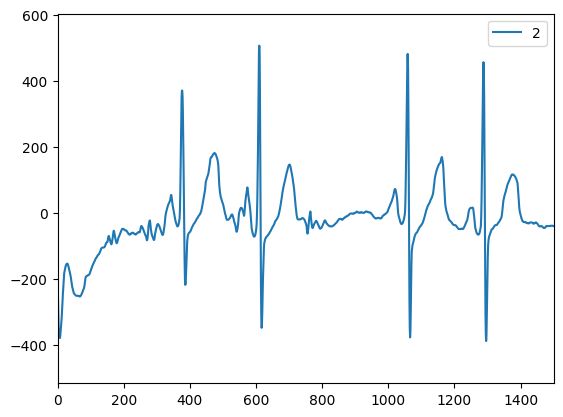

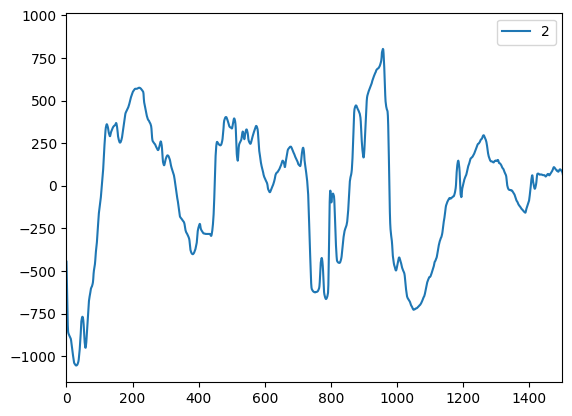

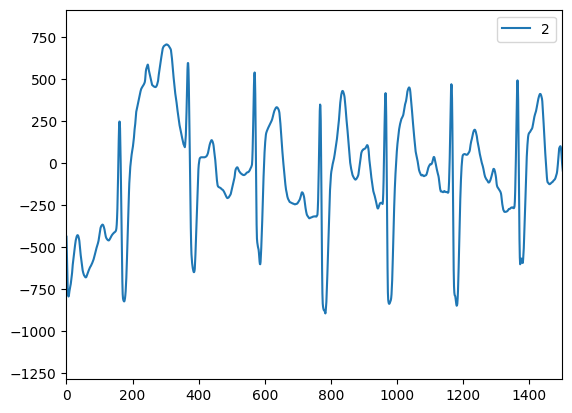

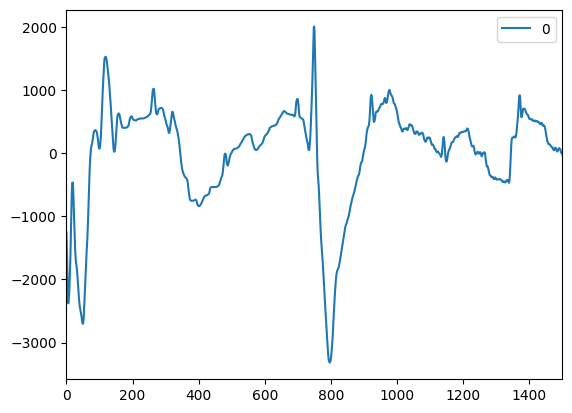

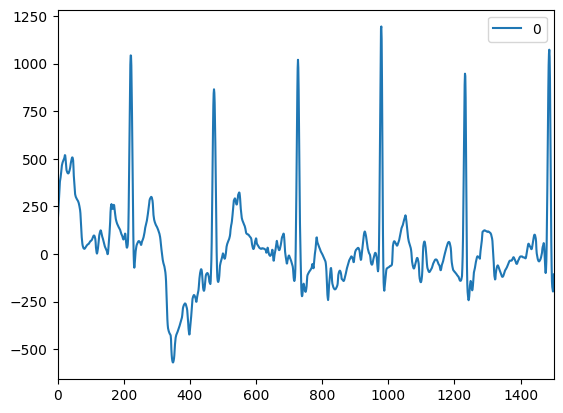

In [121]:
k = 5
ecg_vals = df['Data'][:k].to_numpy()
classes = df['Class'][:k].to_numpy()
mx = 18000

for d, clss in zip(ecg_vals, classes):
  plt.plot(d, label=clss)
  plt.xlim(0, 1500)
  plt.legend()
  plt.show()

## Plot class distribution

Absolute class distribution: [3638  549 1765  227]


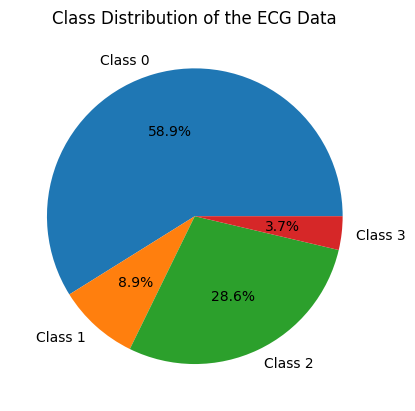

In [122]:
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

_df = df.groupby('Class').count()
count = _df['Data'].to_numpy()
print(f"Absolute class distribution: {count}")

fig, ax = plt.subplots()
ax.pie(count, labels=classes, autopct='%1.1f%%')
plt.title('Class Distribution of the ECG Data')
plt.show()

## Analyze the lengths of the samples

- This information is relevant for model-selection and pre-processing of data for model


In [123]:
unique_lengths, counts = np.unique(df['Lengths'], return_counts=True)
min_val = unique_lengths.min()
max_val = unique_lengths.max()
mean_val = unique_lengths.mean()
most_frequent_length = unique_lengths[np.argmax(counts)]

# print(np.max(counts), counts[np.argmax(counts)])

print(f'Number of all different lengths: {len(unique_lengths)}\n')
print("--- Absolute Lengths ---")
print(f'Min Length: {min_val}')
print(f'Max Length: {max_val}')
print(f'Avg. Length: {mean_val:.2f}')
print(f'Most Frequent Length: {most_frequent_length} with total of {np.max(counts)} occurences\n')

print("--- Class dependant Lengths ---")
mins = df.groupby("Class")["Lengths"].min()
maxs = df.groupby("Class")["Lengths"].max()
avgs = df.groupby("Class")["Lengths"].mean()
print(f"Class 0  --  Min-Length: {mins[0]}  -  Max-Length: {maxs[0]}  -  Avg-Length: {int(avgs[0])}")
print(f"Class 1  --  Min-Length: {mins[1]}  -  Max-Length: {maxs[1]}  -  Avg-Length: {int(avgs[1])}")
print(f"Class 2  --  Min-Length: {mins[2]}  -  Max-Length: {maxs[2]}  -  Avg-Length: {int(avgs[2])}")
print(f"Class 3  --  Min-Length: {mins[3]}  -  Max-Length: {maxs[3]}  -  Avg-Length: {int(avgs[3])}")

Number of all different lengths: 1082

--- Absolute Lengths ---
Min Length: 2714
Max Length: 18286
Avg. Length: 8638.57
Most Frequent Length: 9000 with total of 4341 occurences

--- Class dependant Lengths ---
Class 0  --  Min-Length: 2714  -  Max-Length: 18286  -  Avg-Length: 9662
Class 1  --  Min-Length: 2996  -  Max-Length: 18062  -  Avg-Length: 9510
Class 2  --  Min-Length: 2738  -  Max-Length: 18188  -  Avg-Length: 10366
Class 3  --  Min-Length: 2808  -  Max-Length: 18000  -  Avg-Length: 7210


## Compute descriptive statistics

In [124]:
_df = df.groupby("Class")["Data"].describe()

In [125]:
def get_class_statistics(df: pd.DataFrame, class_: int):

    group = df.groupby("Class")["Data"].get_group(class_)
    all_stats = np.zeros(8)

    for series in group:
        stats = pd.Series(series).describe()
        all_stats += stats

    all_stats /= group.shape[0]
    return all_stats

# df.groupby("Class")["Data"].apply()
count0, mean0, std0, min0, quant0_25, quant0_50, quant0_75, max0 = get_class_statistics(df, 0)
count1, mean1, std1, min1, quant1_25, quant1_50, quant1_75, max1 = get_class_statistics(df, 1)
count2, mean2, std2, min2, quant2_25, quant2_50, quant2_75, max2 = get_class_statistics(df, 2)
count3, mean3, std3, min3, quant3_25, quant3_50, quant3_75, max3 = get_class_statistics(df, 3)

In [126]:
print(f"-- Class 0 -- \n\nCount: {int(count0)}\nMean: {mean0:.2f}\nMin: {min0:.2f}\nMax: {max0:.2f}\n25% Quantile: {quant0_25:.2f}\n50% Quantile: {quant0_50:.2f}\n75% Quantile: {quant0_75:.2f}\n")
print(f"-- Class 1 -- \n\nCount: {int(count1)}\nMean: {mean1:.2f}\nMin: {min1:.2f}\nMax: {max1:.2f}\n25% Quantile: {quant1_25:.2f}\n50% Quantile: {quant1_50:.2f}\n75% Quantile: {quant1_75:.2f}\n")
print(f"-- Class 2 -- \n\nCount: {int(count2)}\nMean: {mean2:.2f}\nMin: {min2:.2f}\nMax: {max2:.2f}\n25% Quantile: {quant2_25:.2f}\n50% Quantile: {quant2_50:.2f}\n75% Quantile: {quant2_75:.2f}\n")
print(f"-- Class 3 -- \n\nCount: {int(count3)}\nMean: {mean3:.2f}\nMin: {min3:.2f}\nMax: {max3:.2f}\n25% Quantile: {quant3_25:.2f}\n50% Quantile: {quant3_50:.2f}\n75% Quantile: {quant3_75:.2f}")

-- Class 0 -- 

Count: 9662
Mean: 7.58
Min: -1069.66
Max: 1289.28
25% Quantile: -69.80
50% Quantile: -9.94
75% Quantile: 64.01

-- Class 1 -- 

Count: 9510
Mean: 8.91
Min: -913.85
Max: 1098.64
25% Quantile: -63.69
50% Quantile: -7.07
75% Quantile: 58.88

-- Class 2 -- 

Count: 10366
Mean: 6.90
Min: -1042.66
Max: 1242.79
25% Quantile: -70.51
50% Quantile: -9.13
75% Quantile: 63.31

-- Class 3 -- 

Count: 7210
Mean: 5.28
Min: -2304.37
Max: 2392.21
25% Quantile: -163.33
50% Quantile: -0.52
75% Quantile: 179.52


In [127]:
# # compute the mean
# df["Mean"] = df["Data"].apply(lambda sample: sample.mean())
# df["Std"] = df["Data"].apply(lambda sample: sample.std())
# df["Min"] = df["Data"].apply(lambda sample: sample.min())
# df["Max"] = df["Data"].apply(lambda sample: sample.max())

# fig, axs = plt.subplots(2, 2, figsize=(20,18))

# # plot stats
# total = 0

# for i in range(len(classes)):

#   grouped = df.groupby("Labels").get_group(i)
#   mean = grouped["Mean"].to_numpy()
#   std = grouped["Std"].to_numpy()
#   min = grouped["Min"].to_numpy()
#   max = grouped["Max"].to_numpy()
#   total += len(grouped)

#   axs[0, 0].plot(mean, label=classes[i])
#   axs[0, 0].set_title("Mean Distribution of each Class")
#   axs[0, 0].legend()
#   axs[0, 0].set_xlim(0, 40)
#   # axs[0, 0].set_ylim(-50, 50)

#   axs[0, 1].plot(std, label=classes[i])
#   axs[0, 1].set_title("Std Distribution of each Class")
#   axs[0, 1].legend()
#   axs[0, 1].set_xlim(0, 40)

#   axs[1, 0].plot(min, label=classes[i])
#   axs[1, 0].set_title("Min Distribution of each Class")
#   axs[1, 0].legend()
#   axs[1, 0].set_xlim(0, 40)

#   axs[1, 1].plot(max, label=classes[i])
#   axs[1, 1].set_title("Max Distribution of each Class")
#   axs[1, 1].legend()
#   axs[1, 1].set_xlim(0, 40)

# plt.legend()
# plt.show()

# print(f"Total Samples: {total}")
# # df.groupby("Labels")["Data"]

In [128]:
# take the samples with length=9000
df2 = df[df.Lengths == 9000].groupby("Class").mean()
data = df2['Data'].to_numpy()

# plt.figure()
# end = 3
# for p, lbl in zip(data[:end], classes[:end]):
#     plt.plot(p, label=lbl)
# # plt.plot(df['Data'][81])

# x_lim = 800
# y_lim = 40
# plt.xlim((0, x_lim))
# plt.ylim((-y_lim, y_lim))
# plt.legend()
# plt.show()

# print(df2['Data'].to_numpy().sum())
test = df[df.Lengths == 9000].groupby("Class").count()
test["Total"] = df.groupby("Class").count()["Data"]
test["Ratio"] = test["Lengths"] / test["Total"]
print(f'\n\nStatistics of Data Points of length: 9000')
test.head()

# df2.head()



Statistics of Data Points of length: 9000


,Data,Lengths,Total,Ratio
Class,,,,
0,2664,2664,3638,0.732270
1,377,377,549,0.686703
2,1196,1196,1765,0.677620
3,104,104,227,0.458150


- Make data pecessible and compute: Mean, Std., Mode

18286


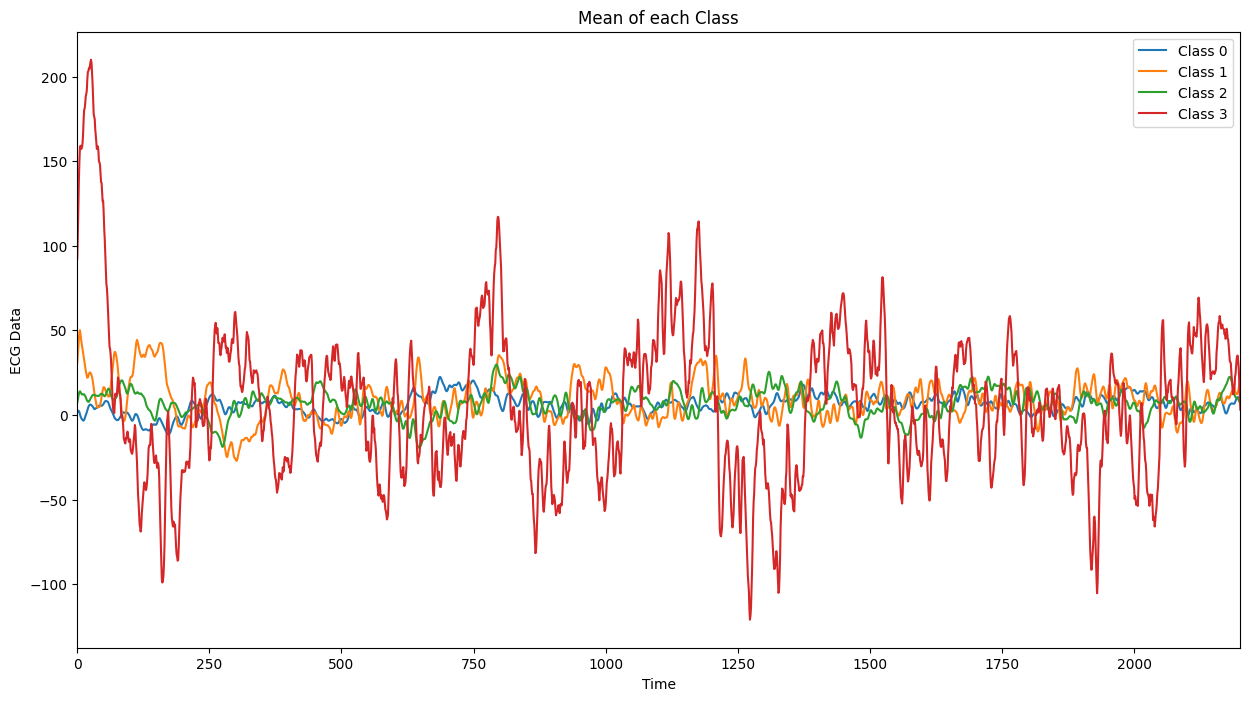

Class
0    [1.6478834524463992, 2.324354040681693, 2.6047...
1    [31.114754098360656, 35.68488160291439, 40.666...
2    [7.430594900849858, 9.224929178470255, 11.0600...
3    [92.54185022026432, 106.02643171806167, 122.63...
Name: Data, dtype: object

In [129]:
# take the longest data point
max_len = df["Lengths"].max()
print(max_len)
# use zero-padding to make all data points to same length
df['Data'] = df['Data'].apply(lambda ts: np.pad(ts, (0, max_len - ts.shape[0])))

# compute mean of each class
mean = df.groupby("Class")["Data"].mean()
# median = df.groupby("Labels")["Data"].std(axis=1)
# plot the data
plt.figure(figsize=(15, 8))
for ts, _class in zip(mean.to_numpy(), classes):
    plt.plot(ts, label=_class)

plt.xlim((0, 2200))
# plt.ylim((100, -100))
plt.xlabel("Time")
plt.ylabel("ECG Data")
plt.title("Mean of each Class")
plt.legend()
plt.show()

mean


### Create Training and Validation Split (70/30)

In [ ]:
# create training and validation split
X_train, X_validation, y_train, y_validation = train_test_split(ecg_data, labels, train_size=0.7, random_state=42, stratify=labels)

# verify that the training and validation split is proportional to the original class distribution

counter0 = Counter(labels)
counter1 = Counter(y_train)
counter2 = Counter(y_validation)

total0 = len(labels)
ratios0 = np.array([counter0[0]/total0, counter0[1]/total0, counter0[2]/total0, counter0[3]/total0]) # original dataset ratios

total1 = counter1[0] + counter1[1] + counter1[2] + counter1[3]
ratios1 = np.array([counter1[0]/total1, counter1[1]/total1, counter1[2]/total1, counter1[3]/total1]) # training dataset ratios

total2 = counter2[0] + counter2[1] + counter2[2] + counter2[3]
ratios2 = np.array([counter2[0]/total2, counter2[1]/total2, counter2[2]/total2, counter2[3]/total2]) # validation dataset ratios

assert np.allclose(ratios0, ratios1, atol=1e-3)
assert np.allclose(ratios0, ratios2, atol=1e-3)
assert np.allclose(ratios1, ratios2, atol=1e-3)

# ratios0, ratios1, ratios2
def zero_pad_data(X: list, max_length: int):

    data = []
    for x in X:
        off = max_length - x.shape[0]
        new_x = np.pad(x, (0, off), "constant")
        data.append(new_x)

    return data

# [[0, 1, 2], [2, 3], [2]]
# [[0, 1, 2], [2, 3, 0], [2, 0, 0]]

X_train, y_train = torch.Tensor(zero_pad_data(X_train, max_val)), torch.Tensor(y_train)
X_validation, y_validation = torch.Tensor(zero_pad_data(X_validation, max_val)), torch.Tensor(y_validation)

# Task 1.2 - Modeling and Tuning

Here we define the actual Model architecture

In [ ]:
class ECGNN(nn.Module):
    def __init__(self):
        super(ECGNN, self).__init__()
        self.conv = nn.Conv2d(1, 32, 3)
    
    def forward(self, x: torch.tensor):
        # feature extraction e.g. with scipy.signal.stft or pywt.dwt
        cA, cD = pywt.dwt(x, 'coif1')
        pass

Define the training and test routine

In [145]:
def train(
        model: nn.Module, 
        device: torch.device, 
        train_loader: torch.utils.data.DataLoader, 
        criterion: nn.CrossEntropyLoss,
        optimizer: torch.optim.Optimizer, 
        epoch: int
    ):

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # do forward and backward pass
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # TODO maybe do cross-validation for hyperparameter-tuning
        if batch_idx % 10 == 0:
            data_processed = batch_idx * len(data)
            total_data = len(train_loader.dataset)
            progress = (100. * batch_idx) / len(train_loader)
            print("Train Epoch: {} [{}/{} ({:.0f})] - Loss: {:.6f}".format(
                epoch, data_processed, total_data, progress, loss.item()
            ), end="\r")

def test(
        model: nn.Module, 
        device: torch.device, 
        validation_loader: torch.utils.data.DataLoader,
        criterion: nn.CrossEntropyLoss
    ):

    model.eval()
    test_loss = 0.
    correct = 0

    with torch.no_grad():
        for data, target in validation_loader:
            # do forward pass
            data, target = data.to(device), data.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction="sum").item()
            # compute correct predictions
            preds = output.argmax(dim=1, keepdim=False)
            correct_preds = (preds == target).count_nonzero()
            correct += correct_preds

    test_loss /= len(validation_loader.dataset)
    correct = (100. * correct)  / len(validation_loader.dataset)

In [ ]:
num_samples_per_class = torch.from_numpy(df.groupby("Class").count()["Data"].to_numpy())
weights =  num_samples_per_class.max() / num_samples_per_class

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGNN().to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)

# training and test loop
epochs = 10
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, criterion, optimizer, epoch)
    test(model, device, validation_loader, criterion)

In [ ]:
import torch
a = torch.randint(0, 100, (4, 4))

a, a.argmax(dim=1, keepdim=True)

x = torch.Tensor([1, 2, 3, 4, 5])
y = torch.Tensor([1, 2, 2, 4, 0])
(x == y).count_nonzero

tensor(3)

In [73]:
from scipy.signal import stft
import pywt

x, y, z = stft(X_train[0])
v, w = pywt.dwt(X_train[0], "coif1")
# x.shape, y.shape, v.shape, w.shape
v, w

(array([374.39247323, 317.51151216, 456.07116514, ...,   9.72271824,
         12.53548964,  12.83196614]),
 array([ 26.35370501,   4.2566181 , -10.04657686, ...,  -0.11415378,
         -0.04142116,  -0.4833629 ]))